# Bike Sharing System

This notebook documents the analysis and model development for the Bike Sharing System Dataset

# Overview

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental and bike return is automated via a network of kiosk locations throughout the city. With this setup people can rent a bike from one place and return it in a different location based on the need. The data is analyzed for Capital Bikeshare in Washington DC. The idea is to analyze the current bike sharing demand and to study historical usage patterns with weather data to forecast the demand for bike sharing and predict the usage to improve on the kiosk locations. The data used is hosted by UCI Machine Learning repository. Using the data the trends of bike sharing demand can be analyzed using factors like peak times, weather, routes, traffic, weekday/weekend. 

## Understading the columns in Dataset

* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather - 
   * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
   * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
   * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
   * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals 

## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sn
import pandas.plotting
import scipy.stats

## Importing data

In [2]:
train_data = pd.read_csv('train.csv')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


## Preprocessing the data

In [3]:
# date time conversion
train_data.datetime = pd.to_datetime(train_data.datetime)
train_data['hour'] = train_data.datetime.dt.hour
train_data['month'] = train_data.datetime.dt.month
train_data['year'] = train_data.datetime.dt.year

## Defining features

In [4]:
# Dividing the features into categorical and numerical 
categorical_features = ['season', 'holiday', 'year', 'month', 'hour', 'workingday', 'weather']
number_features = ['temp', 'atemp', 'humidity', 'windspeed']
# Our target here is to estimate the total count of users on any given particular hour
target_feature = ['count']

In [5]:
for col in categorical_features:
    train_data[col] = train_data[col].astype('category')
train_data[categorical_features].describe()

,season,holiday,year,month,hour,workingday,weather
count,10886,10886,10886,10886,10886,10886,10886
unique,4,2,2,12,24,2,4
top,4,0,2012,12,23,1,1
freq,2734,10575,5464,912,456,7412,7192


In [6]:
train_data[number_features].describe()

,temp,atemp,humidity,windspeed
count,10886.00000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395
std,7.79159,8.474601,19.245033,8.164537
min,0.82000,0.760000,0.000000,0.000000
25%,13.94000,16.665000,47.000000,7.001500
50%,20.50000,24.240000,62.000000,12.998000
75%,26.24000,31.060000,77.000000,16.997900
max,41.00000,45.455000,100.000000,56.996900


# Missing Value Check

In [7]:
# Check if any null values are present in data
train_data.isnull().any()

datetime      False
season        False
holiday       False
workingday    False
weather       False
temp          False
atemp         False
humidity      False
windspeed     False
casual        False
registered    False
count         False
hour          False
month         False
year          False
dtype: bool

# Outlier Analysis

## Box plots

[Text(0, 0.5, 'Count'), Text(0.5, 1.0, 'Count')]

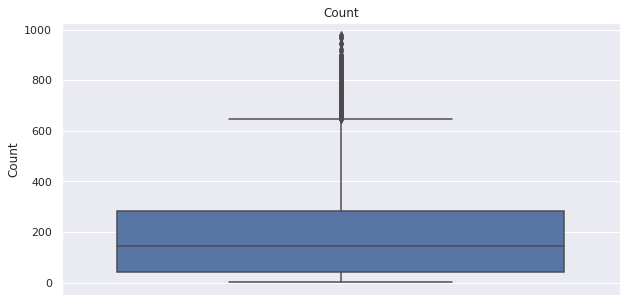

In [8]:
sn.set(font_scale=1.0)
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
sn.boxplot(data=train_data, y = 'count', orient='v', ax=ax)
ax.set(ylabel= 'Count', title = 'Count')

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Month'),
 Text(0.5, 1.0, 'Count Over Months')]

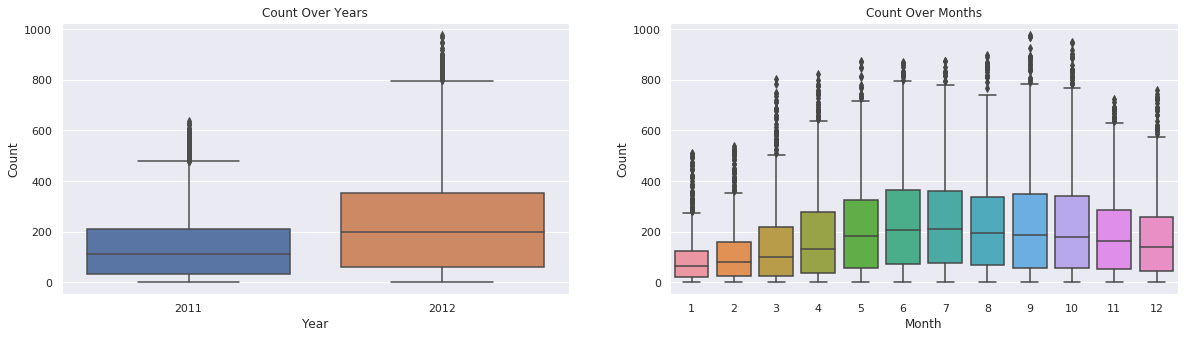

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20, 5)
sn.boxplot(data=train_data, y = 'count', x = 'year', orient='v', ax=ax[0])
ax[0].set(xlabel = 'Year', ylabel= 'Count', title = 'Count Over Years')
sn.boxplot(data=train_data, y = 'count', x = 'month', orient='v', ax=ax[1])
ax[1].set(xlabel='Month', ylabel= 'Count', title = 'Count Over Months')

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Count Over Working/ Non-Working Day')]

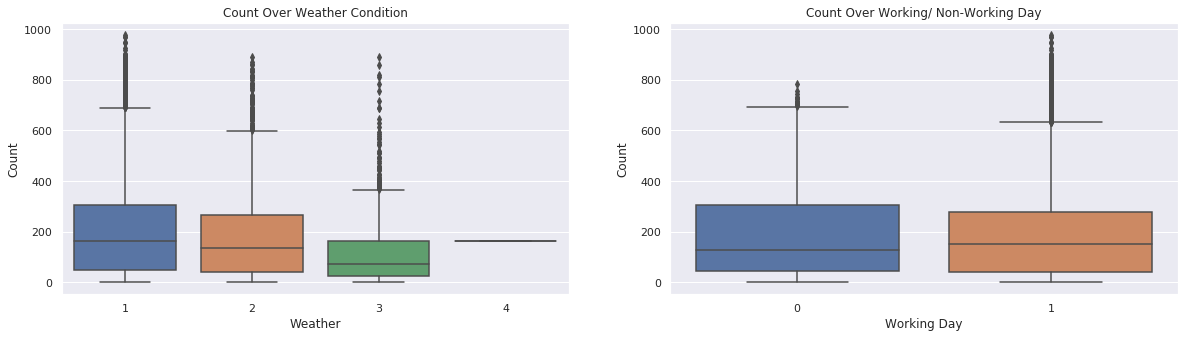

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20, 5)
sn.boxplot(data=train_data, y = 'count', x = 'weather', orient='v', ax=ax[0])
ax[0].set(xlabel='Weather', ylabel= 'Count', title = 'Count Over Weather Condition')
sn.boxplot(data=train_data, y = 'count', x = 'workingday', orient='v', ax=ax[1])
ax[1].set(xlabel='Working Day', ylabel= 'Count', title = 'Count Over Working/ Non-Working Day')

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Temperature'),
 Text(0.5, 1.0, 'Count Over Temperatures')]

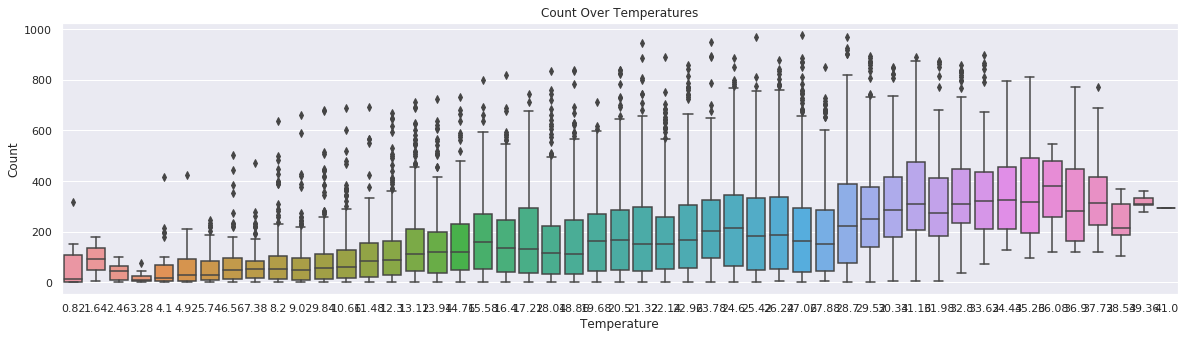

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sn.boxplot(data=train_data, y = 'count', x = 'temp', orient='v', ax=ax)
ax.set(xlabel='Temperature', ylabel= 'Count', title = 'Count Over Temperatures')

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Humidity'),
 Text(0.5, 1.0, 'Count Over Humidity')]

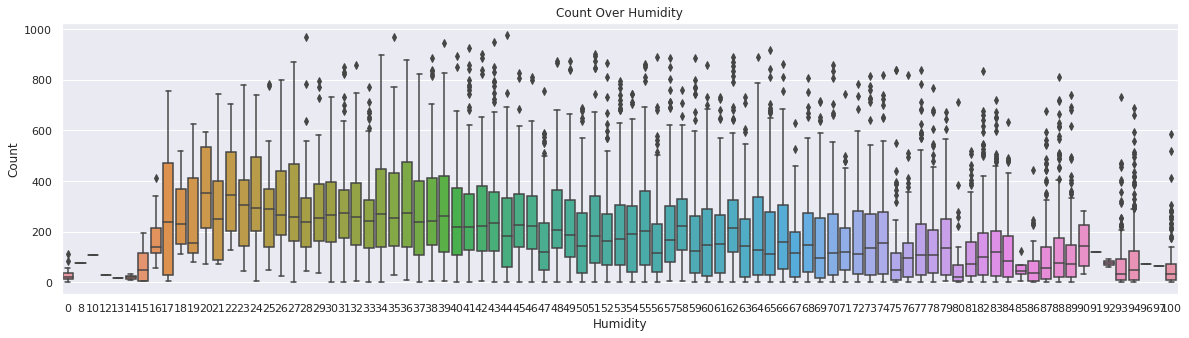

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sn.boxplot(data=train_data, y = 'count', x = 'humidity', orient='v', ax=ax)
ax.set(xlabel='Humidity', ylabel= 'Count', title = 'Count Over Humidity')

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Humidity'),
 Text(0.5, 1.0, 'Count Over Wind Speeds')]

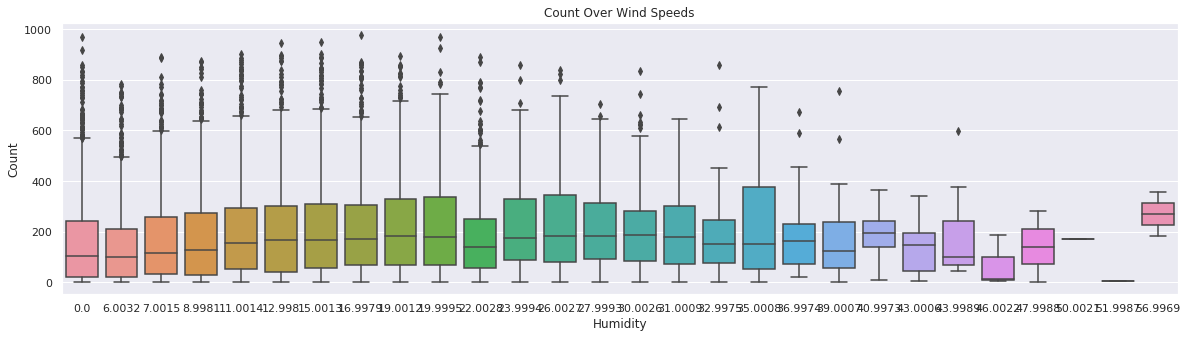

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sn.boxplot(data=train_data, y = 'count', x = 'windspeed', orient='v', ax=ax)
ax.set(xlabel='Humidity', ylabel= 'Count', title = 'Count Over Wind Speeds')

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Hour'),
 Text(0.5, 1.0, 'Count Over Hour on a Day')]

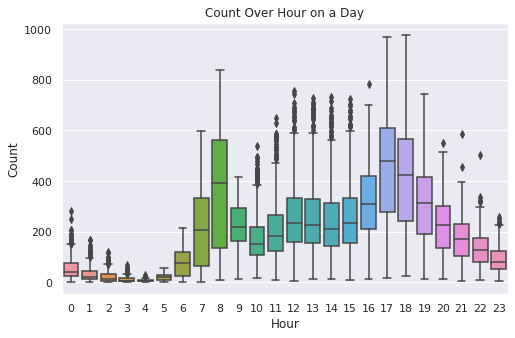

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
sn.boxplot(data=train_data, y = 'count', x = 'hour', orient='v', ax=ax)
ax.set(xlabel='Hour', ylabel= 'Count', title = 'Count Over Hour on a Day')

[Text(0, 0.5, 'Casual Count'),
 Text(0.5, 0, 'Hour'),
 Text(0.5, 1.0, 'Casual Users Over Hour of the Weekend')]

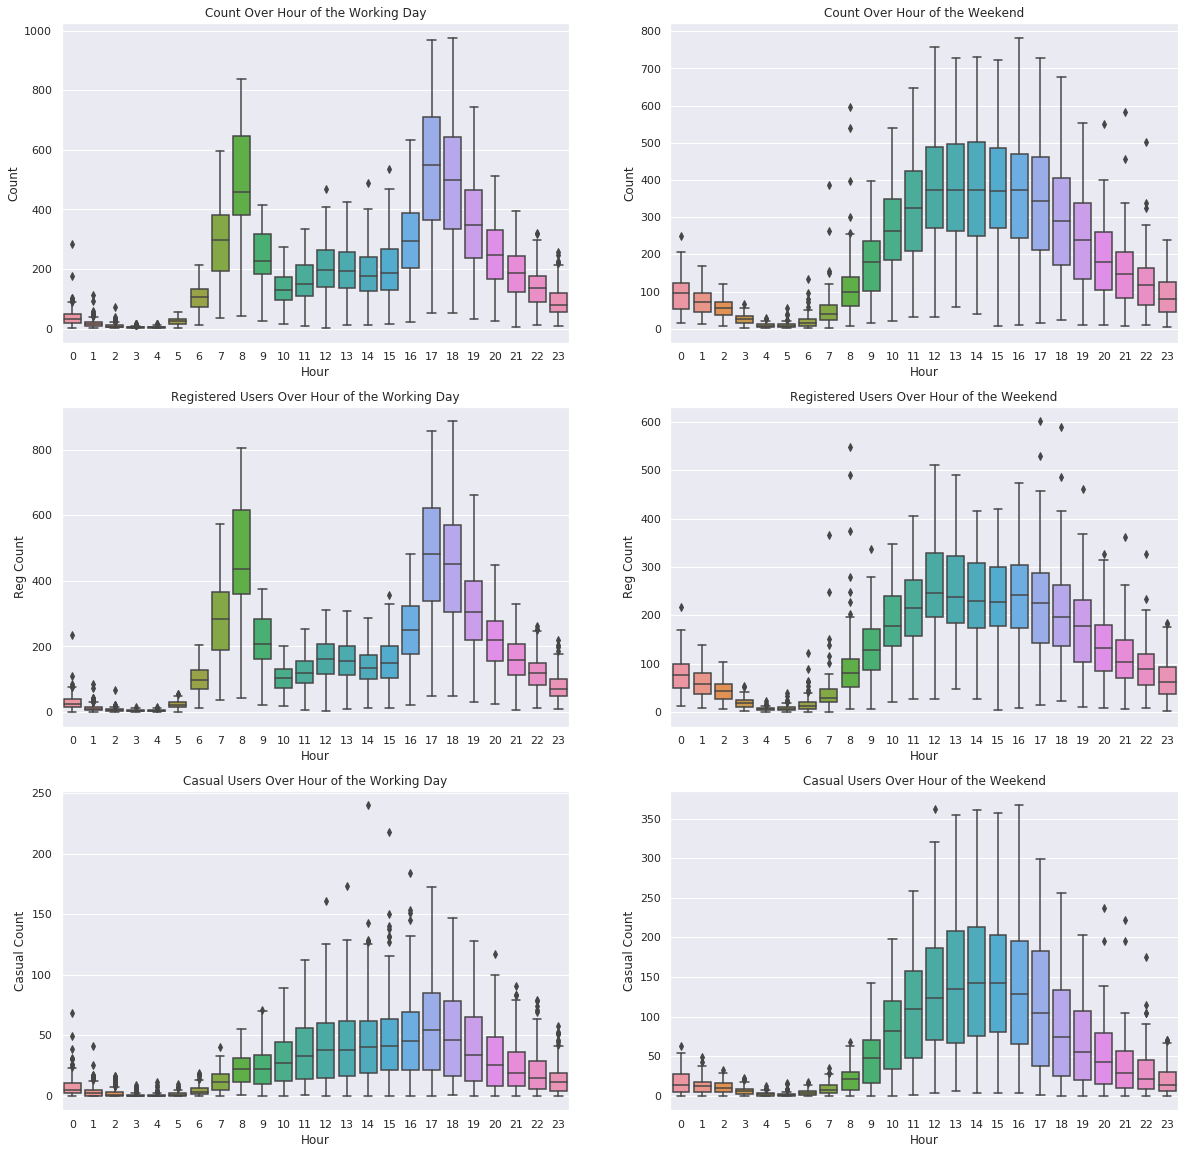

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(20, 20)
sn.boxplot(data=train_data[train_data.workingday == 1], y = 'count', x = 'hour', orient='v', ax=ax[0][0])
ax[0][0].set(xlabel='Hour', ylabel= 'Count', title = 'Count Over Hour of the Working Day')
sn.boxplot(data=train_data[train_data.workingday == 0], y = 'count', x = 'hour', orient='v', ax=ax[0][1])
ax[0][1].set(xlabel='Hour', ylabel= 'Count', title = 'Count Over Hour of the Weekend')

sn.boxplot(data=train_data[train_data.workingday == 1], y = 'registered', x = 'hour', orient='v', ax=ax[1][0])
ax[1][0].set(xlabel='Hour', ylabel= 'Reg Count', title = 'Registered Users Over Hour of the Working Day')
sn.boxplot(data=train_data[train_data.workingday == 0], y = 'registered', x = 'hour', orient='v', ax=ax[1][1])
ax[1][1].set(xlabel='Hour', ylabel= 'Reg Count', title = 'Registered Users Over Hour of the Weekend')

sn.boxplot(data=train_data[train_data.workingday == 1], y = 'casual', x = 'hour', orient='v', ax=ax[2][0])
ax[2][0].set(xlabel='Hour', ylabel= 'Casual Count', title = 'Casual Users Over Hour of the Working Day')
sn.boxplot(data=train_data[train_data.workingday == 0], y = 'casual', x = 'hour', orient='v', ax=ax[2][1])
ax[2][1].set(xlabel='Hour', ylabel= 'Casual Count', title = 'Casual Users Over Hour of the Weekend')

## Interpretation

* Number of bikes rented increased from 2011 to 2012
* Number of bikes rented are high during June & July
* Number of bikes rented are higher when there is a clear weather
* Number of bikes rened increases with temperature that means during cold days there is lesser demand.More outliers are present in lower temperatures.
* Humidity seems to have a negative effect on bike demand
* The trends of count over the hour on a working day and weekend are different. The peak times during working day are 7 AM - 8 AM & 5 PM - 6 PM, this means that office commuters and school going kids are the main users during working days. During weekends the demand is high from 10 AM - 4 PM. The trend over a working day is majorly driven by registered users (compare registered users on working and count). 

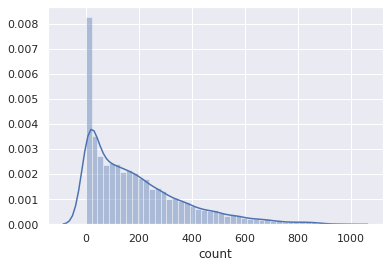

In [16]:
sn.distplot(train_data['count'])

# Correlation Analysis

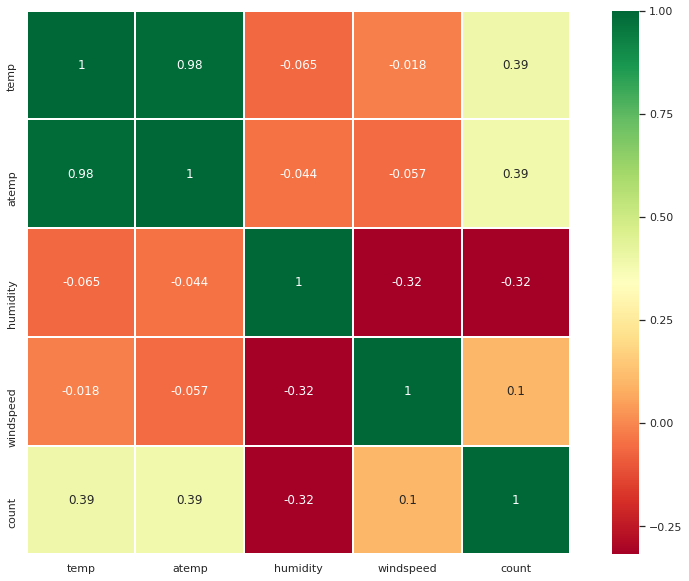

In [17]:
fig, ax = plt.subplots(figsize=(15,10)) 
sn.heatmap(train_data[number_features + target_feature].corr(), linewidths=1, square=True, annot=True, cmap="RdYlGn", ax=ax)
plt.show()

## Interpretation

* Registered and Casual are not considered in the feature set as they are directly related to count
* The variables 'temp' and 'atemp' are highly correlated. 'atemp' can be removed for consideration

In [18]:
number_features.remove('atemp')